In [1]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 292 kB 2.2 MB/s            


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [41]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.6.0


In [112]:
df = pd.read_csv('training_data.csv')

In [113]:
df.tail()

,base_speed,distance_from_wall,rotation_angle,distance_setpoint,docking_time,docking_distance
43,2.5,603.075973,0.010256,500.0,6.054141,1049.0
44,2.5,630.000000,0.000000,500.0,11.070061,1690.0
45,2.5,426.184890,-0.505791,500.0,9.928071,1460.0
46,2.5,531.331454,0.389317,500.0,11.652685,1701.0
47,2.5,671.474343,0.380506,500.0,9.062397,1432.0


In [114]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

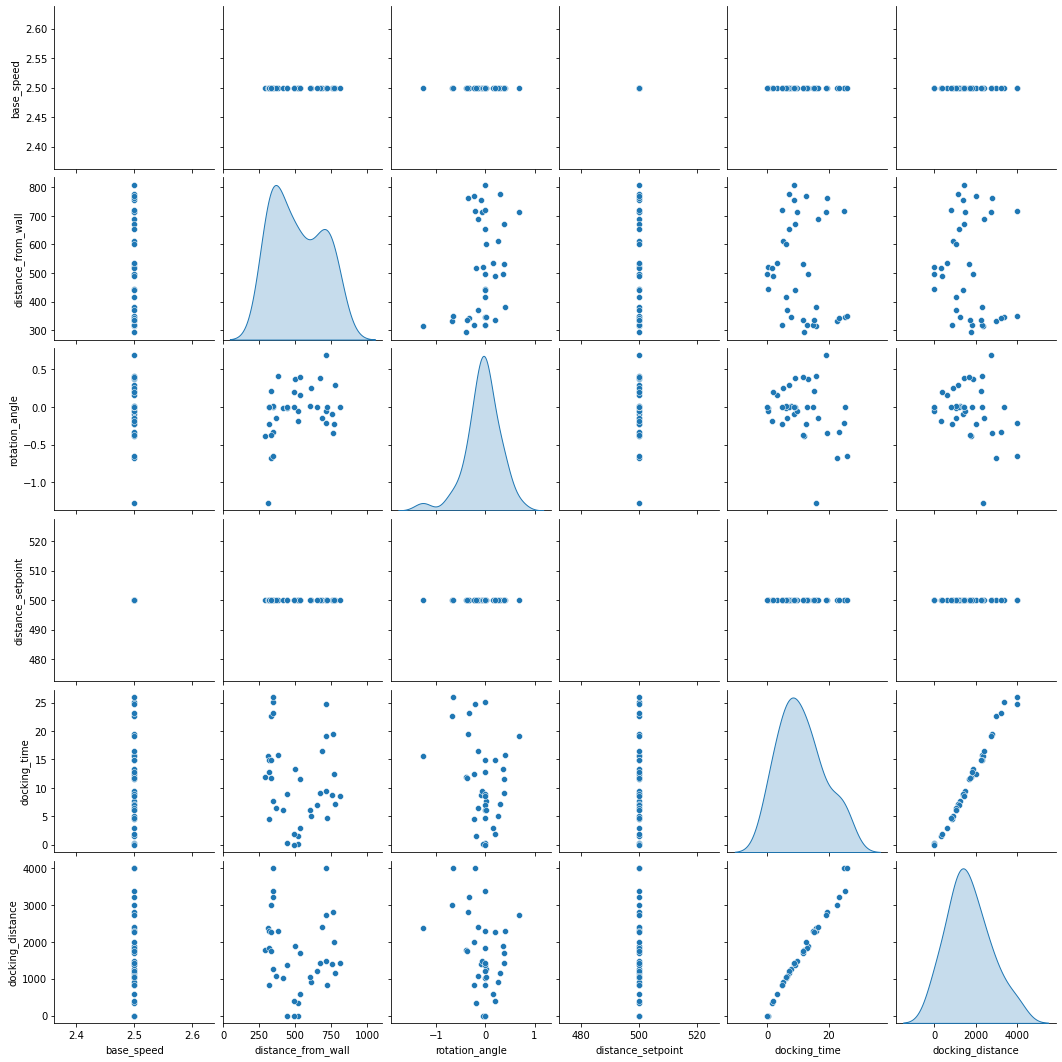

In [115]:
plot=sns.pairplot(train_dataset[['base_speed', 
                            'distance_from_wall', 
                            'rotation_angle', 
                            'distance_setpoint', 
                            'docking_time', 
                            'docking_distance']], 
                            diag_kind='kde'
                            )

In [8]:
plot.savefig('/images/seaborn.png')

FileNotFoundError: [Errno 2] No such file or directory: '/images/seaborn.png'

In [116]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
base_speed,38.0,2.500000,0.000000,2.500000,2.500000,2.500000,2.500000,2.500000
distance_from_wall,38.0,514.894967,170.074067,292.993785,346.156783,495.939912,684.934576,809.669805
rotation_angle,38.0,-0.055673,0.346780,-1.271073,-0.209658,-0.002564,0.117051,0.677860
distance_setpoint,38.0,500.000000,0.000000,500.000000,500.000000,500.000000,500.000000,500.000000
docking_time,38.0,11.002662,7.331200,0.000599,6.068294,9.296343,15.497448,25.983634
docking_distance,38.0,1669.315789,1037.094775,0.000000,1034.750000,1457.000000,2285.250000,4000.000000


In [117]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('docking_distance')
t=train_features.pop('docking_time')

test_labels = test_features.pop('docking_distance')
t=test_features.pop('docking_time')

# Normalization

In [118]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
base_speed,2.500000,0.000000
distance_from_wall,514.894967,170.074067
rotation_angle,-0.055673,0.346780
distance_setpoint,500.000000,0.000000
docking_time,11.002662,7.331200
docking_distance,1669.315789,1037.094775


In [119]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [120]:
normalizer.adapt(np.array(train_features))

In [121]:
print(normalizer.mean.numpy())

[[  2.5   514.895  -0.056 500.   ]]


# Regresja liniowa

In [122]:
distance_from_wall = np.array(train_features['distance_from_wall'])

dfw_normalizer = layers.Normalization(input_shape=[1,], axis=None)
dfw_normalizer.adapt(distance_from_wall)

In [123]:
dfw_model = tf.keras.Sequential([
    dfw_normalizer,
    layers.Dense(units=1)
])

dfw_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [124]:
dfw_model.predict(distance_from_wall[:5])

array([[ 0.065],
       [-0.046],
       [ 0.055],
       [-0.036],
       [-0.06 ]], dtype=float32)

In [125]:
dfw_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [126]:
history = dfw_model.fit(
    train_features['distance_from_wall'],
    train_labels, 
    epochs=200, 
    verbose=0, 
    validation_split=0.01
)

In [127]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch 
hist.tail()

,loss,val_loss,epoch
195,1659.853516,791.165894,195
196,1659.697266,790.997742,196
197,1659.538208,790.833679,197
198,1659.382568,790.675110,198
199,1659.222778,790.519226,199


In [128]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2500])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [129]:
test_results = {}
test_results['distance_from_wall'] = dfw_model.evaluate(
    test_features['distance_from_wall'],
    test_labels, verbose=0
)

In [130]:
x = tf.linspace(250, 750, 300)
y = dfw_model.predict(x)

In [131]:
def plot_dfw(x,y):
    plt.scatter(train_features['distance_from_wall'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('distance_from_wall')
    plt.ylabel('Docking distance')
    plt.legend()

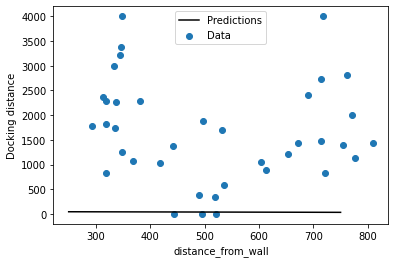

In [132]:
plot_dfw(x,y)

# Linear regression with multiple inputs

In [133]:
linear_model = tf.keras.Sequential([
    normalizer, 
    layers.Dense(units=1)
])

In [65]:
linear_model.predict(train_features[:10])

array([[ 0.094],
       [-0.246],
       [ 0.446],
       [ 0.334],
       [ 0.153],
       [-0.109],
       [-0.034],
       [ 0.188],
       [-0.711],
       [ 0.567]], dtype=float32)

In [134]:
linear_model.layers[1].kernel

<tf.Variable 'dense_17/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.349],
       [ 0.176],
       [ 0.248],
       [-0.575]], dtype=float32)>

In [135]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [136]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

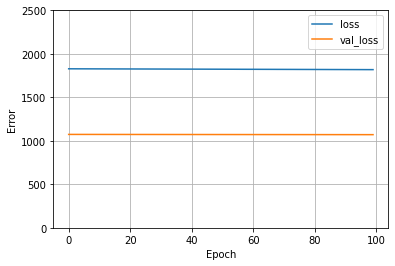

In [137]:
plot_loss(history)

In [138]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Regression with a deep neural network (DNN)

In [139]:
def build_and_compile(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'), 
        layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.001))

    return model

## Multiple inputs

In [140]:
dnn_model = build_and_compile(normalizer)
dnn_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 4)                 9         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 129       
Total params: 17,290
Trainable params: 17,281
Non-trainable params: 9
_________________________________________________________________


In [141]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=1500)

CPU times: user 27.4 s, sys: 2.24 s, total: 29.7 s
Wall time: 25 s


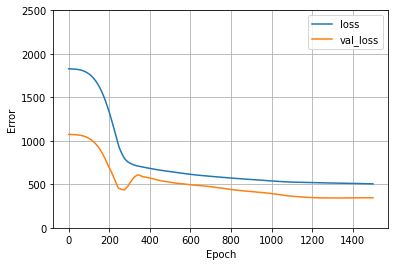

In [142]:
plot_loss(history)

In [143]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)
print(test_results['dnn_model'])

504.06707763671875


# Make predictions

In [148]:
test_predictions = dnn_model.predict(test_features).flatten()

print(test_predictions)
test_labels = list(test_labels)

print(test_labels)

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [Docking Distance]')
# plt.ylabel('Predictions [Docking Distance]')
# lims = [0, 50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

[1926.094 1059.866 3720.205 1610.65  1022.928 1062.467 1856.451  627.353
  833.511 1940.009]
[1356.0, 1010.0, 2698.0, 2006.0, 960.0, 2245.0, 1870.0, 1035.0, 1690.0, 1460.0]
